# 이미지 어디까지 우려볼까?

* Augmentation을 모델 학습에 적용하기
* Augmentation의 적용을 통한 학습 효과 확인하기
* 최신 data augmentation 기법 구현 및 활용하기

## Augmentation 적용 (1) 데이터 불러오기

In [1]:
# 필요한 라이브러리 불러오기
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# GPU 환경 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

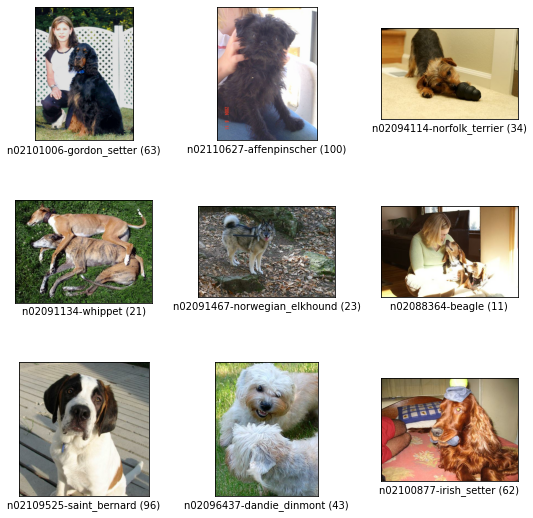

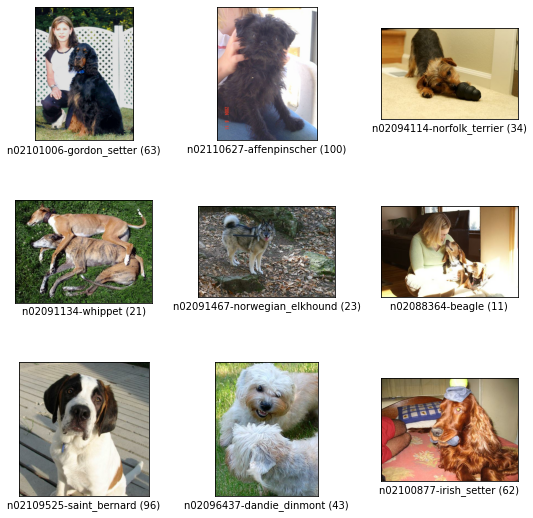

In [4]:
tfds.show_examples(ds_train, ds_info)

## Augmentation 적용 (2) Augmentation 적용하기

In [5]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [6]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [7]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
def augment2(image,label):
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00))
    image = tf.image.resize(image, [224, 224])
    return image, label

## Augmentation 적용 (3) 비교실험 하기

In [9]:
num_classes = ds_info.features["label"].num_classes
'''
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
'''

"\nresnet50 = keras.models.Sequential([\n    keras.applications.resnet.ResNet50(\n        include_top=False,\n        weights='imagenet',\n        input_shape=(224,224,3),\n        pooling='avg',\n    ),\n    keras.layers.Dense(num_classes, activation='softmax')\n])\n"

In [10]:
'''
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
'''

"\naug_resnet50 = keras.models.Sequential([\n    keras.applications.resnet.ResNet50(\n        include_top=False,\n        weights='imagenet',\n        input_shape=(224,224,3),\n        pooling='avg',\n    ),\n    keras.layers.Dense(num_classes, activation='softmax')\n])\n"

In [11]:

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)


In [12]:
'''
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 3

resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)
'''

"\n#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수\nEPOCH = 3\n\nresnet50.compile(\n    loss='sparse_categorical_crossentropy',\n    optimizer=tf.keras.optimizers.SGD(lr=0.01),\n    metrics=['accuracy'],\n)\n\nhistory_resnet50_no_aug = resnet50.fit(\n    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용\n    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),\n    validation_steps=int(ds_info.splits['test'].num_examples/16),\n    epochs=EPOCH,\n    validation_data=ds_test,\n    verbose=1,\n    use_multiprocessing=True,\n)\n"

In [13]:
'''
aug_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)
'''

"\naug_resnet50.compile(\n    loss='sparse_categorical_crossentropy',\n    optimizer=tf.keras.optimizers.SGD(lr=0.01),\n    metrics=['accuracy'],\n)\n\nhistory_resnet50_aug = aug_resnet50.fit(\n    ds_train_aug, # augmentation 적용한 데이터셋 사용\n    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),\n    validation_steps=int(ds_info.splits['test'].num_examples/16),\n    epochs=EPOCH,\n    validation_data=ds_test,\n    verbose=1,\n    use_multiprocessing=True,\n)\n"

In [14]:
'''
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()
'''

"\nplt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')\nplt.plot(history_resnet50_aug.history['val_accuracy'], 'b')\nplt.title('Model validation accuracy')\nplt.ylabel('Accuracy')\nplt.xlabel('Epoch')\nplt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')\nplt.show()\n"

In [15]:
'''
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()
'''

"\nplt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')\nplt.plot(history_resnet50_aug.history['val_accuracy'], 'b')\nplt.title('Model validation accuracy')\nplt.ylabel('Accuracy')\nplt.xlabel('Epoch')\nplt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')\nplt.grid(True)\nplt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. \n#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. \nplt.show()\n"

## 심화 기법 (1) Cutmix Augmentation

### 1) 이미지 섞기

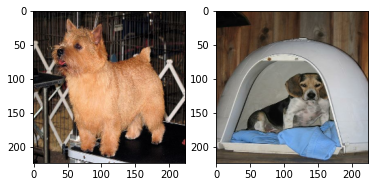

In [16]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [17]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(158, shape=(), dtype=int32) tf.Tensor(204, shape=(), dtype=int32)
y :  tf.Tensor(164, shape=(), dtype=int32) tf.Tensor(204, shape=(), dtype=int32)


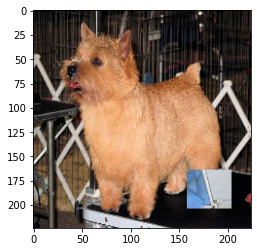

In [18]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

### 2) 라벨 섞기
***

In [19]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.03667092, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.9633291 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [20]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

## 심화 기법 (2) Mixup Augmentation

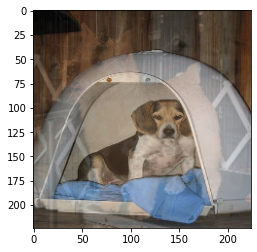

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.7707691
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.22923088
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.     

In [21]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [22]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

# 프로젝트: CutMix 또는 Mixup 비교실험 하기

## Augmentation을 적용한 데이터셋 만들기

In [23]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )

    if not is_test and with_aug:
        ds = ds.map(
            augment
        )

    ds = ds.batch(batch_size)

    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )

    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )

    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )

    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)

    return ds


In [24]:
def onehot(image, label) :
    label = tf.one_hot(label, num_classes)
    return image, label

## 모델 만들기

In [25]:
(ds_train,ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train','test'],
    as_supervised = True,
    shuffle_files = True,
    with_info = True,
)

ds_train_no_aug = apply_normalize_on_dataset(ds_train,with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train,with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train,with_cutmix=True)
ds_train_cutmix_aug = apply_normalize_on_dataset(ds_train,with_aug=True,with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train,with_mixup=True)
ds_train_mixup_aug = apply_normalize_on_dataset(ds_train,with_aug=True,with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test,is_test=True)

In [26]:
# No Augmentation

num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [27]:
# 기본 Augmentation

aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [28]:
# No Augmentation + CutMix

cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [29]:
# 기본 Augmentation + CutMix

aug_cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [30]:
# No Augmentation + Mixup

mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [31]:
# 기본 Augmentation + Mixup

aug_mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

## 모델 훈련하기

In [32]:
# ResNet 50 (No Augmentation)
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

# 기본 Augumentation
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

# No Augmentation + cutmix
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

# 기본 Augmentation + cutmix
aug_cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

# No Augmentation + mixup
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

# 기본 Augmentation + mixup
aug_mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [33]:
EPOCH = 20

In [34]:
# ResNet 50 (No Augmentation) 학습

history_resnet50_no_aug = resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 100s 119ms/step - loss: 2.2591 - accuracy: 0.4321 - val_loss: 2.9155 - val_accuracy: 0.2743
Epoch 2/20
750/750 [==============================] - 93s 125ms/step - loss: 0.9554 - accuracy: 0.7222 - val_loss: 1.3656 - val_accuracy: 0.6100
Epoch 3/20
750/750 [==============================] - 89s 118ms/step - loss: 0.5352 - accuracy: 0.8506 - val_loss: 1.1400 - val_accuracy: 0.6728
Epoch 4/20
750/750 [==============================] - 93s 125ms/step - loss: 0.2759 - accuracy: 0.9322 - val_loss: 1.0666 - val_accuracy: 0.6950
Epoch 5/20
750/750 [==============================] - 89s 118ms/step - loss: 0.1483 - accuracy: 0.9693 - val_loss: 1.0222 - val_accuracy: 0.7069
Epoch 6/20
750/750 [==============================] - 90s 120ms/step - loss: 0.0799 - accuracy: 0.9892 - val_loss: 0.9777 - val_accuracy: 0.7233
Epoch 7/20
750/750 [==============================] - 89s 119ms/step - loss: 0.0455 - accuracy: 0.9948 - val_loss: 0.9874 - val_a

In [35]:
# 기본 Augumentation

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 98s 119ms/step - loss: 2.2760 - accuracy: 0.4333 - val_loss: 2.9942 - val_accuracy: 0.2522
Epoch 2/20
750/750 [==============================] - 88s 118ms/step - loss: 0.9439 - accuracy: 0.7308 - val_loss: 1.1572 - val_accuracy: 0.6567
Epoch 3/20
750/750 [==============================] - 88s 118ms/step - loss: 0.5318 - accuracy: 0.8523 - val_loss: 1.1228 - val_accuracy: 0.6750
Epoch 4/20
750/750 [==============================] - 101s 134ms/step - loss: 0.3174 - accuracy: 0.9202 - val_loss: 1.1346 - val_accuracy: 0.6733
Epoch 5/20
750/750 [==============================] - 99s 132ms/step - loss: 0.1904 - accuracy: 0.9578 - val_loss: 1.1546 - val_accuracy: 0.6813
Epoch 6/20
750/750 [==============================] - 89s 119ms/step - loss: 0.1313 - accuracy: 0.9747 - val_loss: 1.1024 - val_accuracy: 0.6943
Epoch 7/20
750/750 [==============================] - 93s 124ms/step - loss: 0.0634 - accuracy: 0.9916 - val_loss: 0.9949 - val_a

In [36]:
# No Augmentation + cutmix

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 103s 125ms/step - loss: 2.2894 - accuracy: 0.4317 - val_loss: 3.1123 - val_accuracy: 0.2640
Epoch 2/20
750/750 [==============================] - 89s 118ms/step - loss: 0.9481 - accuracy: 0.7325 - val_loss: 1.7062 - val_accuracy: 0.5373
Epoch 3/20
750/750 [==============================] - 88s 118ms/step - loss: 0.4937 - accuracy: 0.8658 - val_loss: 1.2439 - val_accuracy: 0.6512
Epoch 4/20
750/750 [==============================] - 88s 118ms/step - loss: 0.2592 - accuracy: 0.9389 - val_loss: 1.7049 - val_accuracy: 0.5627
Epoch 5/20
750/750 [==============================] - 89s 118ms/step - loss: 0.1385 - accuracy: 0.9739 - val_loss: 1.0889 - val_accuracy: 0.6950
Epoch 6/20
750/750 [==============================] - 89s 118ms/step - loss: 0.1199 - accuracy: 0.9784 - val_loss: 1.0580 - val_accuracy: 0.7077
Epoch 7/20
750/750 [==============================] - 89s 119ms/step - loss: 0.0553 - accuracy: 0.9924 - val_loss: 1.0116 - val_a

In [37]:
# 기본 Augmentation + cutmix

history_resnet50_aug_cutmix = aug_cutmix_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 98s 119ms/step - loss: 2.2763 - accuracy: 0.4283 - val_loss: 3.2946 - val_accuracy: 0.2045
Epoch 2/20
750/750 [==============================] - 88s 117ms/step - loss: 0.9904 - accuracy: 0.7169 - val_loss: 1.2400 - val_accuracy: 0.6402
Epoch 3/20
750/750 [==============================] - 88s 118ms/step - loss: 0.5630 - accuracy: 0.8390 - val_loss: 1.1263 - val_accuracy: 0.6733
Epoch 4/20
750/750 [==============================] - 89s 118ms/step - loss: 0.3489 - accuracy: 0.9094 - val_loss: 1.1259 - val_accuracy: 0.6833
Epoch 5/20
750/750 [==============================] - 89s 119ms/step - loss: 0.1976 - accuracy: 0.9557 - val_loss: 1.1082 - val_accuracy: 0.6946
Epoch 6/20
750/750 [==============================] - 89s 119ms/step - loss: 0.1136 - accuracy: 0.9789 - val_loss: 1.1104 - val_accuracy: 0.6950
Epoch 7/20
750/750 [==============================] - 89s 119ms/step - loss: 0.0758 - accuracy: 0.9878 - val_loss: 0.9642 - val_ac

In [38]:
# No Augmentation + mixup

history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 98s 119ms/step - loss: 2.2793 - accuracy: 0.4341 - val_loss: 2.9361 - val_accuracy: 0.2750
Epoch 2/20
750/750 [==============================] - 89s 119ms/step - loss: 0.9453 - accuracy: 0.7301 - val_loss: 1.3335 - val_accuracy: 0.6157
Epoch 3/20
750/750 [==============================] - 89s 119ms/step - loss: 0.4724 - accuracy: 0.8746 - val_loss: 1.3613 - val_accuracy: 0.6245
Epoch 4/20
750/750 [==============================] - 89s 119ms/step - loss: 0.2539 - accuracy: 0.9417 - val_loss: 1.0756 - val_accuracy: 0.6926
Epoch 5/20
750/750 [==============================] - 89s 119ms/step - loss: 0.1976 - accuracy: 0.9566 - val_loss: 1.1240 - val_accuracy: 0.6918
Epoch 6/20
750/750 [==============================] - 90s 120ms/step - loss: 0.1015 - accuracy: 0.9822 - val_loss: 1.0163 - val_accuracy: 0.7177
Epoch 7/20
750/750 [==============================] - 90s 121ms/step - loss: 0.0510 - accuracy: 0.9937 - val_loss: 0.9234 - val_ac

In [39]:
# 기본 Augmentation + mixup

history_resnet50_aug_mixup = aug_mixup_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 98s 119ms/step - loss: 2.2775 - accuracy: 0.4303 - val_loss: 2.8361 - val_accuracy: 0.2964
Epoch 2/20
750/750 [==============================] - 89s 118ms/step - loss: 0.9478 - accuracy: 0.7263 - val_loss: 1.2232 - val_accuracy: 0.6398
Epoch 3/20
750/750 [==============================] - 89s 119ms/step - loss: 0.5165 - accuracy: 0.8579 - val_loss: 1.1139 - val_accuracy: 0.6786
Epoch 4/20
750/750 [==============================] - 89s 119ms/step - loss: 0.2884 - accuracy: 0.9311 - val_loss: 0.9907 - val_accuracy: 0.7109
Epoch 5/20
750/750 [==============================] - 89s 119ms/step - loss: 0.1465 - accuracy: 0.9713 - val_loss: 1.0156 - val_accuracy: 0.7114
Epoch 6/20
750/750 [==============================] - 89s 119ms/step - loss: 0.0999 - accuracy: 0.9822 - val_loss: 1.0604 - val_accuracy: 0.6995
Epoch 7/20
750/750 [==============================] - 90s 120ms/step - loss: 0.0941 - accuracy: 0.9833 - val_loss: 1.1098 - val_ac

## 훈련 과정 시각화하기

Train Accuracy & Loss

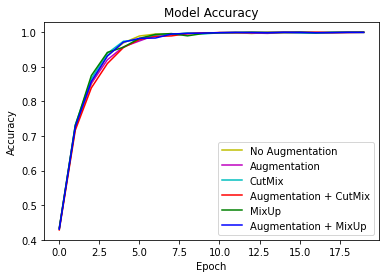

In [52]:
# Training Accuracy

plt.plot(history_resnet50_no_aug.history['accuracy'], 'y')
plt.plot(history_resnet50_aug.history['accuracy'], 'm')
plt.plot(history_resnet50_cutmix.history['accuracy'], 'c')
plt.plot(history_resnet50_aug_cutmix.history['accuracy'], 'r')
plt.plot(history_resnet50_mixup.history['accuracy'], 'g')
plt.plot(history_resnet50_aug_mixup.history['accuracy'], 'b')

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation','CutMix',
           'Augmentation + CutMix','MixUp','Augmentation + MixUp'],loc='lower right')
plt.show()

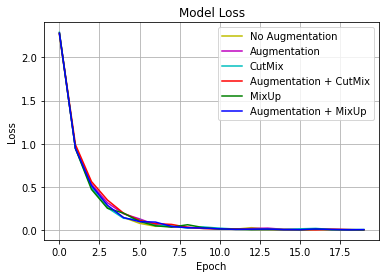

In [43]:
# Training Loss

plt.plot(history_resnet50_no_aug.history['loss'], 'y')
plt.plot(history_resnet50_aug.history['loss'], 'm')
plt.plot(history_resnet50_cutmix.history['loss'], 'c')
plt.plot(history_resnet50_aug_cutmix.history['loss'], 'r')
plt.plot(history_resnet50_mixup.history['loss'], 'g')
plt.plot(history_resnet50_aug_mixup.history['loss'], 'b')

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation','CutMix',
           'Augmentation + CutMix','MixUp','Augmentation + MixUp'],loc='upper right')
plt.grid(True)
plt.show()

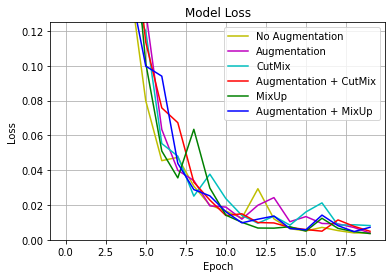

In [47]:
# Training Loss

plt.plot(history_resnet50_no_aug.history['loss'], 'y')
plt.plot(history_resnet50_aug.history['loss'], 'm')
plt.plot(history_resnet50_cutmix.history['loss'], 'c')
plt.plot(history_resnet50_aug_cutmix.history['loss'], 'r')
plt.plot(history_resnet50_mixup.history['loss'], 'g')
plt.plot(history_resnet50_aug_mixup.history['loss'], 'b')

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation','CutMix',
           'Augmentation + CutMix','MixUp','Augmentation + MixUp'],loc='upper right')
plt.grid(True)
plt.ylim(0, 0.125)
plt.show()

Validation Accuracy & Loss

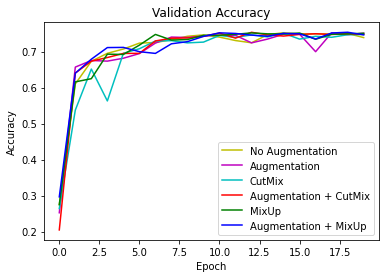

In [53]:
# Validation Accuracy

plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'y')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'm')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'c')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'r')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'g')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'b')

plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation','CutMix',
           'Augmentation + CutMix','MixUp','Augmentation + MixUp'],loc='lower right')
plt.show()

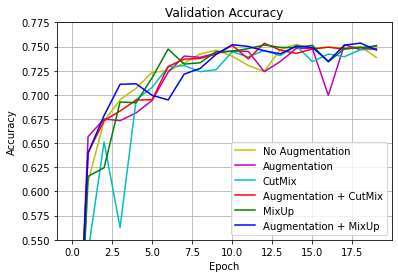

In [55]:
# Validation Accuracy

plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'y')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'm')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'c')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'r')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'g')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'b')

plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation','CutMix',
           'Augmentation + CutMix','MixUp','Augmentation + MixUp'],loc='lower right')
plt.grid(True)
plt.ylim(0.55, 0.775)
plt.show()

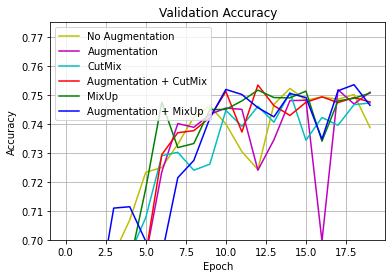

In [61]:
# Validation Accuracy

plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'y')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'm')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'c')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'r')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'g')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'b')

plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation','CutMix',
           'Augmentation + CutMix','MixUp','Augmentation + MixUp'],loc='upper left')
plt.grid(True)
plt.ylim(0.7, 0.775)
plt.show()

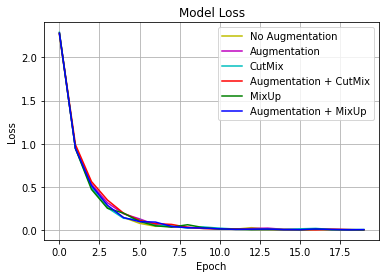

In [57]:
# Validation Loss

plt.plot(history_resnet50_no_aug.history['loss'], 'y')
plt.plot(history_resnet50_aug.history['loss'], 'm')
plt.plot(history_resnet50_cutmix.history['loss'], 'c')
plt.plot(history_resnet50_aug_cutmix.history['loss'], 'r')
plt.plot(history_resnet50_mixup.history['loss'], 'g')
plt.plot(history_resnet50_aug_mixup.history['loss'], 'b')

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation','CutMix',
           'Augmentation + CutMix','MixUp','Augmentation + MixUp'],loc='upper right')
plt.grid(True)
plt.show()

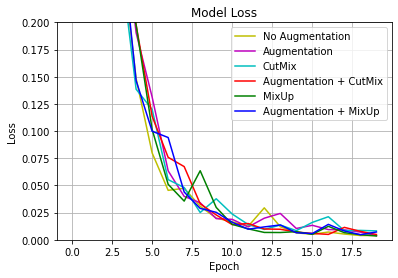

In [59]:
# Validation Loss

plt.plot(history_resnet50_no_aug.history['loss'], 'y')
plt.plot(history_resnet50_aug.history['loss'], 'm')
plt.plot(history_resnet50_cutmix.history['loss'], 'c')
plt.plot(history_resnet50_aug_cutmix.history['loss'], 'r')
plt.plot(history_resnet50_mixup.history['loss'], 'g')
plt.plot(history_resnet50_aug_mixup.history['loss'], 'b')

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation','CutMix',
           'Augmentation + CutMix','MixUp','Augmentation + MixUp'],loc='upper right')
plt.grid(True)
plt.ylim(0, 0.2)
plt.show()

## Augmentation에 의한 모델 성능 비교